# Поиск мотива

## 1. Извлечение из БД сигналов всех типов

Можно работать напрямую с базой данных, но предварительный экспорт сигналов в бинарном виде экономит время.  
**Фильтрация**: извлекаются только такие SV, второй брейкпоинт которых не попадает в окрестность первого. (length > 256bp)

In [1]:
import sqlite3
con = sqlite3.connect('file:../hgdp_2022-04-12.db?mode=ro', uri=True)
cur = con.cursor()

In [2]:
!mkdir -p bin0412

In [6]:
files = {}
cur.execute(f"SELECT s.coverage, s.size, s.type, s.side FROM signal as s")

for sig, size, tp, side in cur.fetchall():
    if size < 256: continue
    name = f"bin0412/HGDP_{tp}_{side}_filterd.bin"
    if name not in files: files[name] = open(name, 'wb')
    files[name].write(sig)

for name in files:
    print(f" -> {name}")
    files[name].close()

 -> bin0412/HGDP_DEL_L_filterd.bin
 -> bin0412/HGDP_DEL_R_filterd.bin
 -> bin0412/HGDP_DUP_L_filterd.bin
 -> bin0412/HGDP_DUP_R_filterd.bin
 -> bin0412/HGDP_CNV_loss_L_filterd.bin
 -> bin0412/HGDP_CNV_loss_R_filterd.bin
 -> bin0412/HGDP_CNV_gain_L_filterd.bin
 -> bin0412/HGDP_CNV_gain_R_filterd.bin
 -> bin0412/HGDP_INV_L_filterd.bin
 -> bin0412/HGDP_INV_R_filterd.bin


## 2. Кластеризация. Бустрап, силуэт-индекс

Определение оптимального числа кластеров для кластеризации сигналов. 
Оценивается одтельно для каждого типа SV.  
Для работы требуется бинарный файл с сигналами определённого типа (получены на предыдущем шаге).

```bash
# Подсчёт силуэт-индекса на случайных 100 регионах 100 раз. 
# Среднее время работы 6 часов для каждого файла (n.jobs = 32):
for src in bin0412/*.bin; do 
  python3 Silhouette_KM.py $src 100 100; 
done
```

### Результаты

По оси X число кластеров, по Y силуэт-индекс:

In [3]:
import glob, json, os
import numpy as np
import matplotlib.pyplot as plt

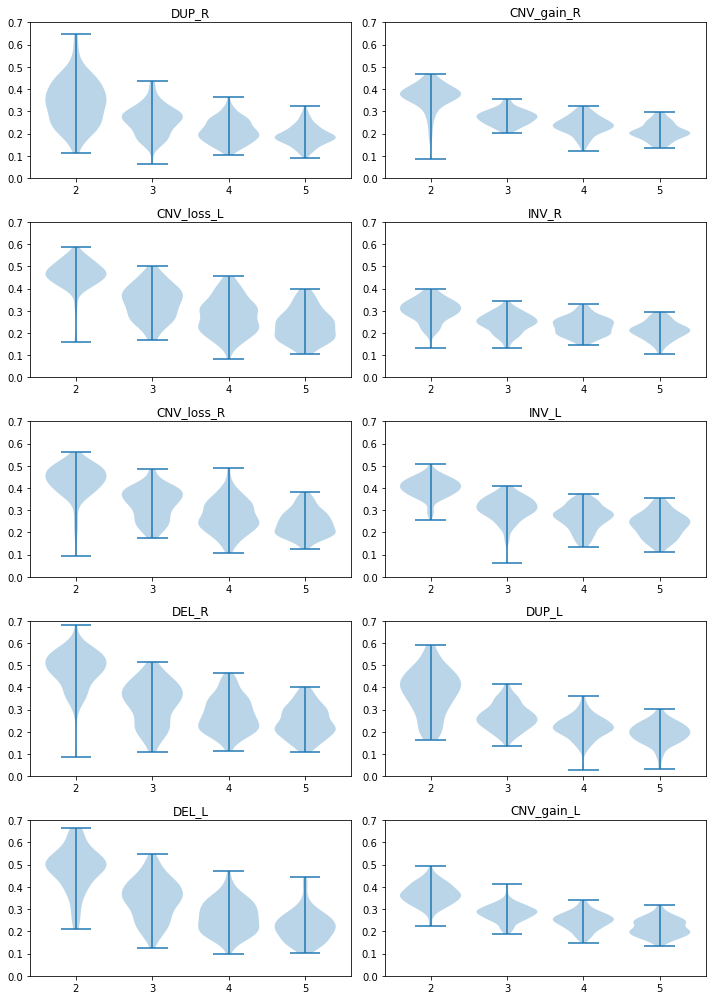

In [4]:
fig, axs = plt.subplots(5, 2, figsize=(10, 14))
for ax, js in zip(axs.flat, glob.glob('./bin0412/silhouette_*.json')):
    name = os.path.basename(js).replace('silhouette_HGDP_', '').replace('.json', '')
    ax.set_title(f'{name}')
    with open(js, 'r') as f:
        table = json.load(f)
        vp = ax.violinplot(np.array(table), [2, 3, 4, 5], widths=0.8)
        ax.set(xlim=(1.4, 5.6), xticks=np.arange(2, 6), ylim=(0, 0.7))
fig.tight_layout()

Из графиков видно, что кластеризация более чем на два класса не оправдана

## 3. Допустимость сжатия сигнала для кластеризации

В целях экономии времени допустимо сжать сигнал в 8 раз. Проверка:  
1. Набор сигналов из БД кластеризуется (дважды, с разным `seed`-ом), получаем два варианта кластеризации (`C0` и `С1`)
2. Набор сигналов сжимается в 8 раз, кластеризуется снова (вариант `C2`).
3. Подсчитывается процент элементов `P1`, которые сохранили индикатор класса вне зависимости от `seed`-а — сравниваем `C0` с `C1`.
4. Подсчитывается процент элементов `P2`, которые сохранили индикатор класса до сжатия сигнала и после — сравниваем `C0` с `C2`.
5. Сравниваются распределения `P1` и `P2`

```bash
# Среднее время работы = 4 часа для каждого файла (n.jobs = 32):
for src in bin0412/*.bin; do 
  python3 Clusters_Compress.py $src 100; 
done
```

### Результаты

На графиках показана доля элементов, которая сохранила индикатор класса. 
Видно, что если сжать сигнал в 8 раз, часть элементов выборки всё же меняет класс (гистограмма `compressed`). 
Однако, при отсутствии сжатия но при изменении начальных условий для K-means, в среднем меньше элементов сохраняют изначальный индикатор класса (гистограмма `seed`):

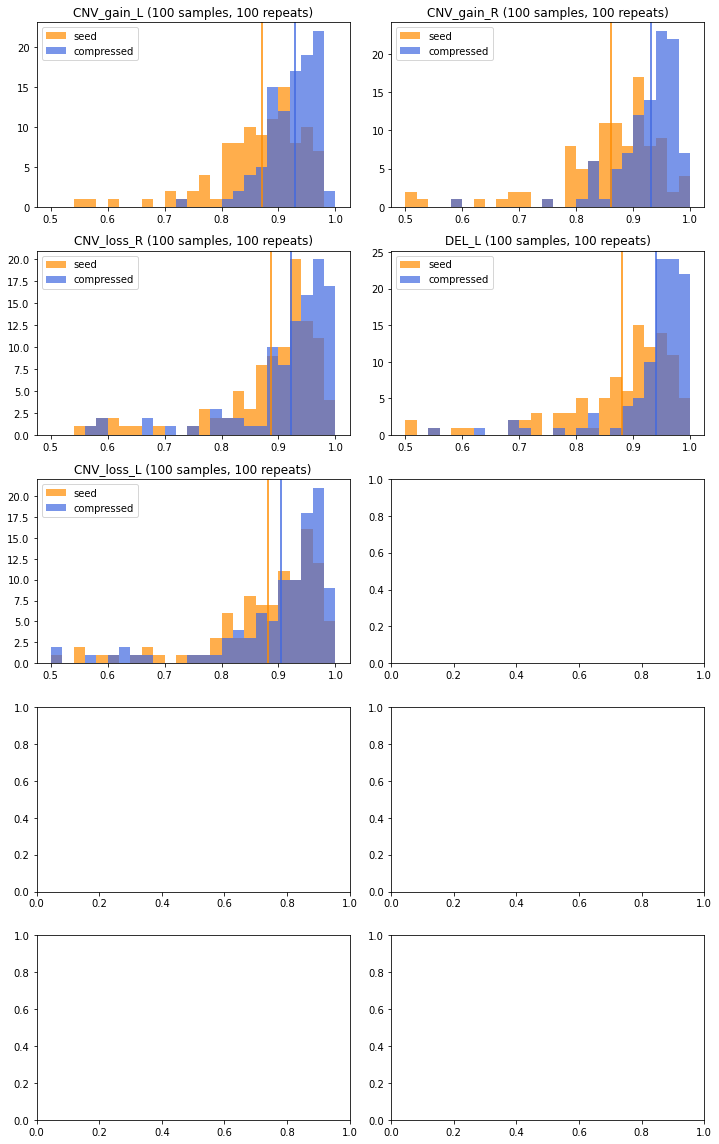

In [5]:
fig, axs = plt.subplots(5, 2, figsize=(10, 16))
for ax, js in zip(axs.flat, glob.glob('./bin0412/compress_*.json')):
    name = os.path.basename(js).replace('compress_HGDP_', '').replace('.json', '')
    with open(js, 'r') as f:
        table = json.load(f)
        labels = [('seed', 'darkorange', 1,), ('compressed', 'royalblue', 2,)] # label, color, index
        ax.set_title(f'{name} ({table[1][0]} samples, {len(table[1][1])} repeats)')
        for l, c, i in labels:
            ax.hist(table[1][i], bins=np.arange(0.5, 1.02, 0.02), label=l, alpha=0.7, color=c)
            ax.axvline(x=np.mean(table[1][i]), color=c)
        ax.legend()
fig.tight_layout()

## 4. Поиск мотива для каждого кластера

На предыдущих шагах показано, что разделение на 2 кластера является оптимальным. 
Теперь сжимаем данные в 8 раз и осуществляем кластеризацию на 2 кластера методом K-Means, используя расстояние `dtw` (пакет `tslearn.metrics`). Для каждого найденного кластера ищем мотивы в несжатых данных модифицированным алгоритмом `KMS` с двумя фиксированными, а не случайно выбранными "базисами".

Кластеризация проводится множество раз на новых выборках (бутстрап). 
Далее классы выравниваются друг относительно друга используя минимальное расстояние `dtw` между усреднёнными значениями кластеров.

```bash
# Около 20 часов работы для 10000 образцов и 80 повторов, можно запускать параллельно (&), не требует многопоточности
for src in ./bin0412/*.bin; do
  python3 Clusters_KMS_bootstrap.py src:$src dataset:10000 repeats:80 &
done
```

### Результаты

Ниже приведены графики для 5 самых значимых мотивов (колонки) на 6 независимых прогонах на разных случайных подвыборках полного датасета (строки). В аннотации указан процент кандидатов в мотивы, которые образовали мотив на графике. Например, если исходноый набор данных был 2000 сигналов, то в больший кластер для делеций попадёт 1627 из них. Каждый из сигналов кластера будет разложен на 9 фрагментов скользящим окном. Итого 1627 * 9 = 14643 кандидатов в мотивы. 246 из них оказались на достаточно близком расстоянии друг от друга и были объединены в мотив на 1 графике в 1 строке.

График для DEL_L, размер случайной подвыборки из БД = 2000 сигналов, SAX сжатие 64x32, размер скользящего окна 32, 40 независимых прогонов, 6 из которых показаны:

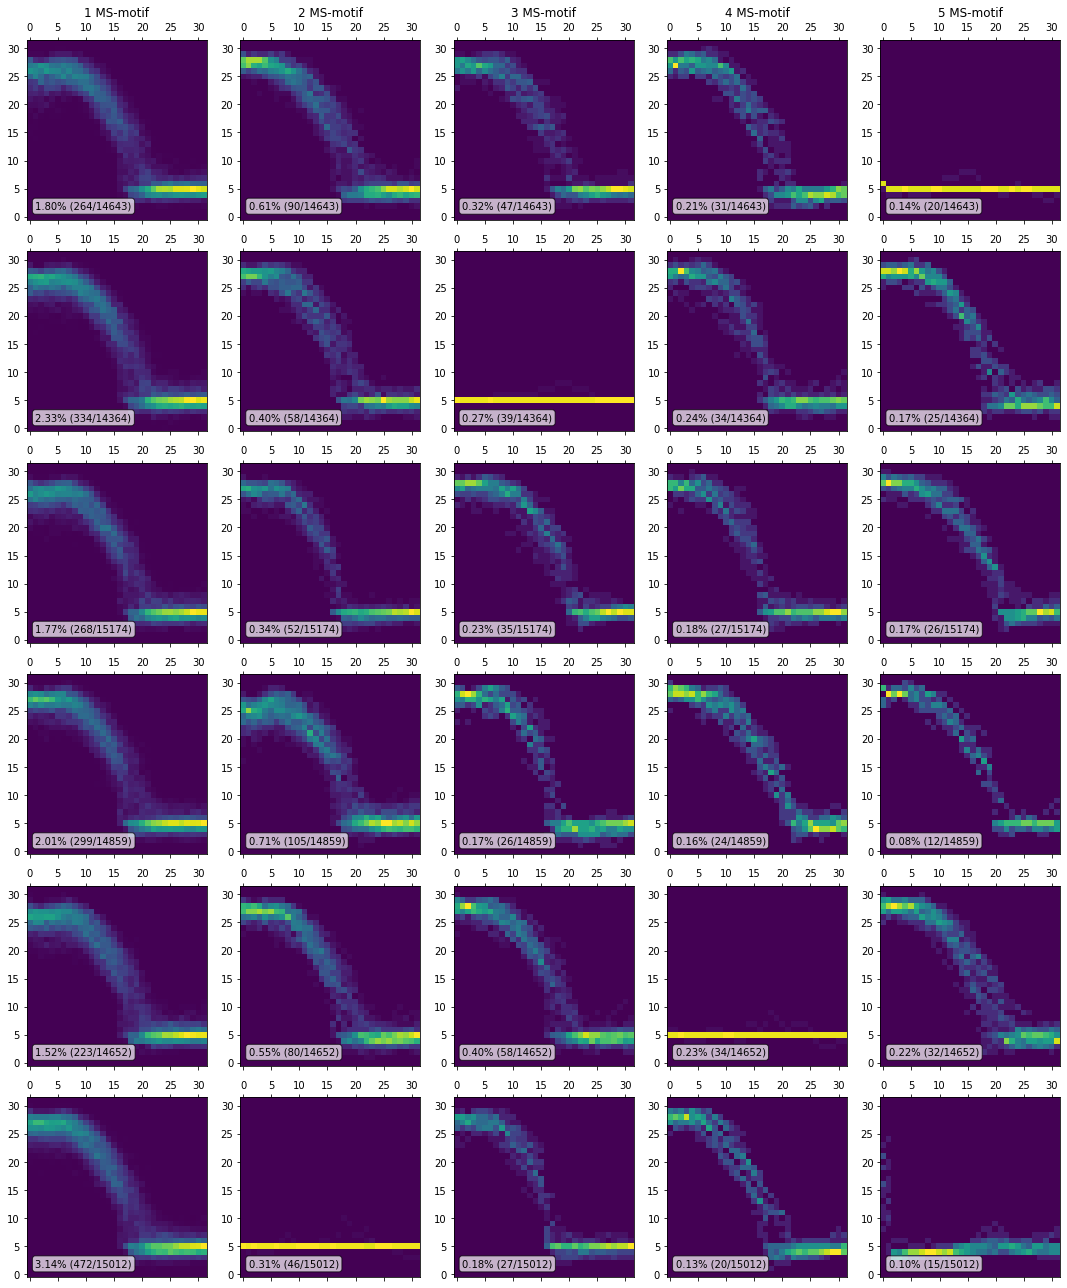

In [6]:
bbox = dict(boxstyle="round", fc="white", alpha=0.7, ec="k", lw=1)
with open('bin0412/motif_HGDP_DEL_L_s64-32_w32_d2000_r40.json', 'r') as f:
    A, B = json.load(f)

fig, axs = plt.subplots(6, 5, figsize=(5*3, 6*3))
for row, a in zip(axs, A[0:6]):
    for ax, mt in zip(row, a['motif']):
        ax.matshow(np.transpose(np.array(mt['m'])), origin='lower')
        s = '{:.2f}% ({:d}/{:d})'.format(100 * mt['items']/a['subs'], mt['items'], a['subs'])
        ax.text(1, 1, s, ha="left", va="bottom", size=10, bbox=bbox)
for n, ax in enumerate(axs[0]):
    ax.set_title(f"{n+1} MS-motif")
fig.tight_layout()

На графиках фидно, что в зависимости от выборки значимость мотивов может измениться. 
Например, тривиальный мотив в _первой_ строке отмечен на _пятом_ месте по значимости, а во _второй_ строке — на _третьем_. 
Это усложняет бустраппинг и требует дополнительного выравнивания мотивов для каждого прогона. Выравнивание осуществляется с помощтю SAX-расстояния между мотивами, функции расположены в файле `group_motif.py`   

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

#### CNV_gain_L

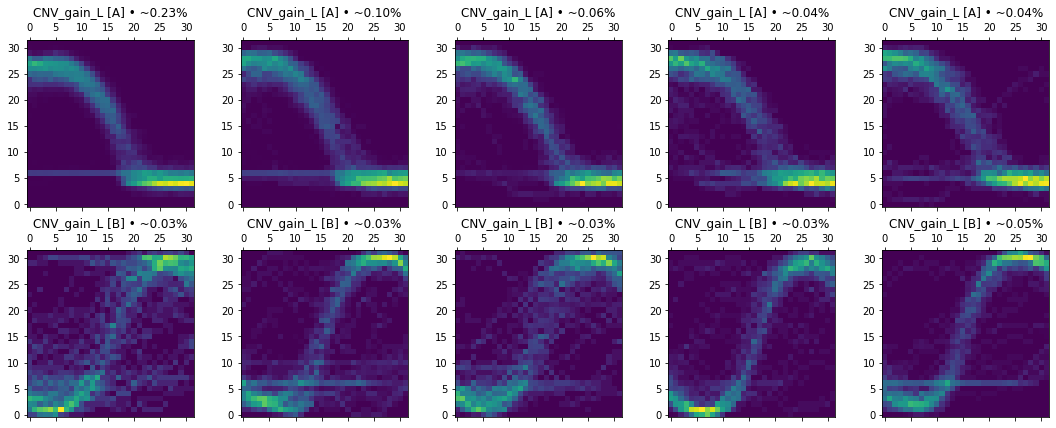

#### CNV_gain_R

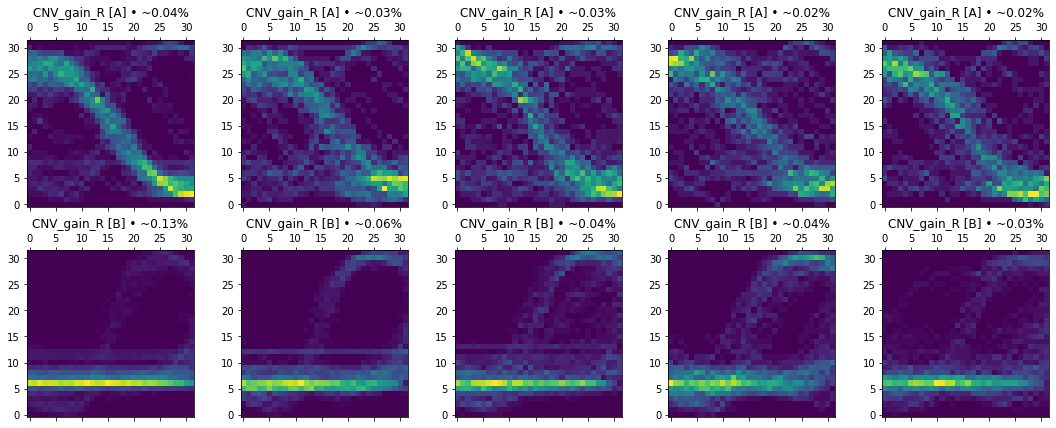

#### CNV_loss_L

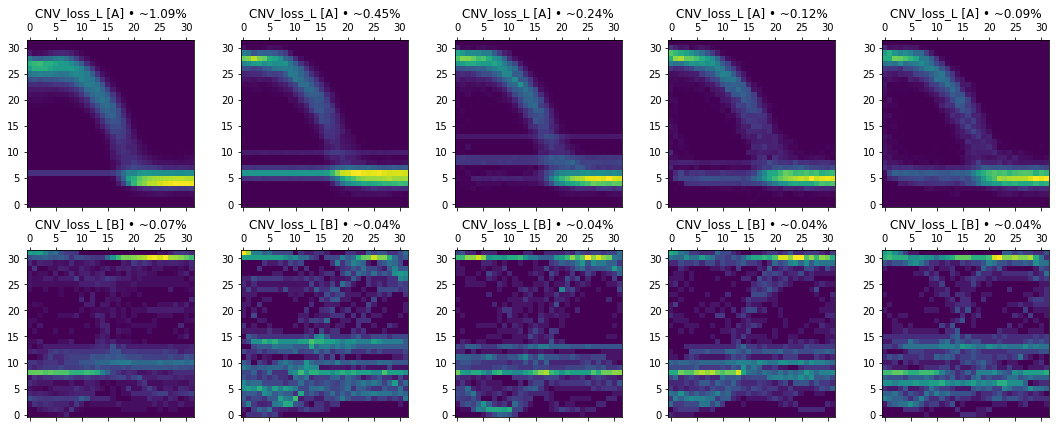

#### CNV_loss_R

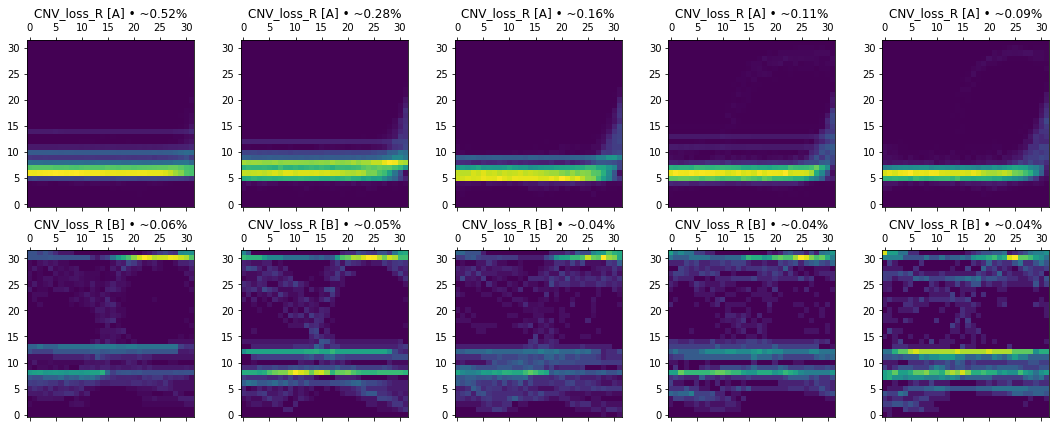

#### DEL_L

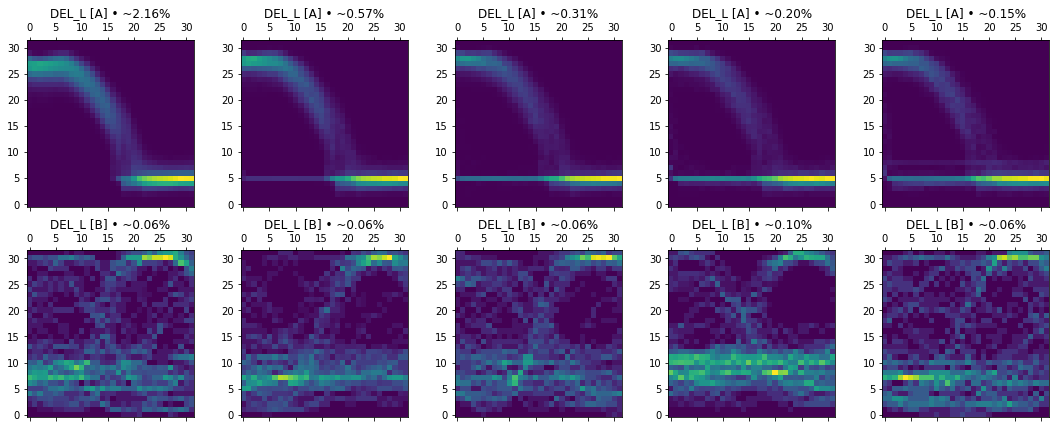

#### DEL_R

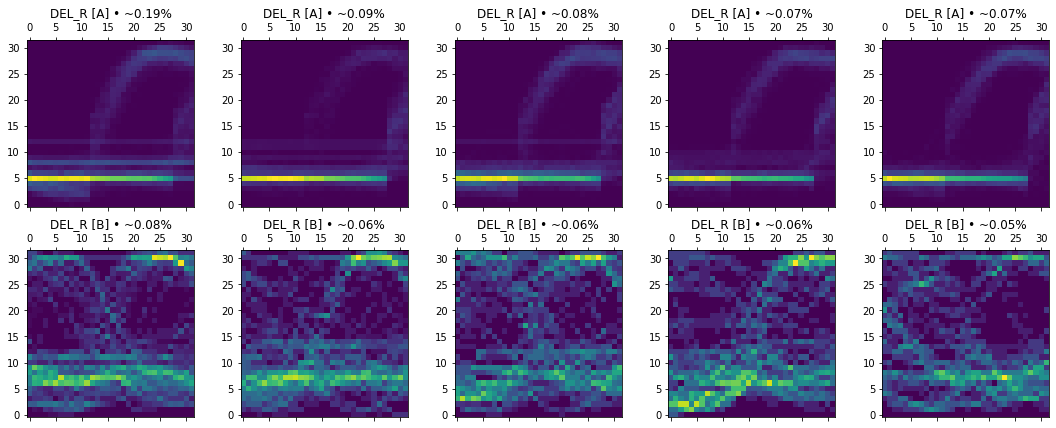

#### DUP_L

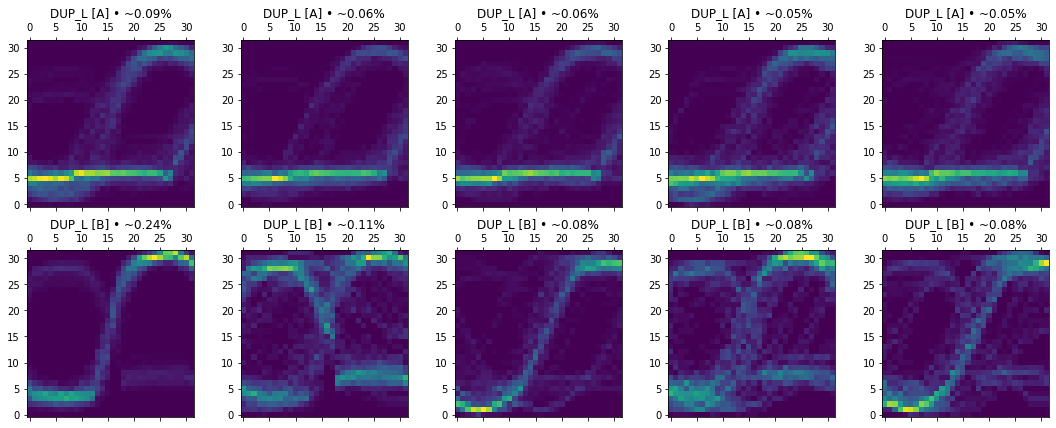

#### DUP_R

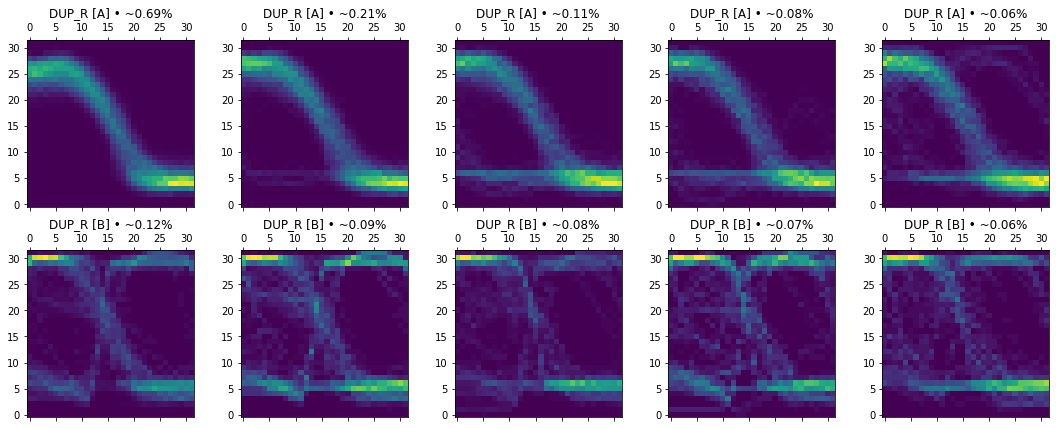

#### INV_L

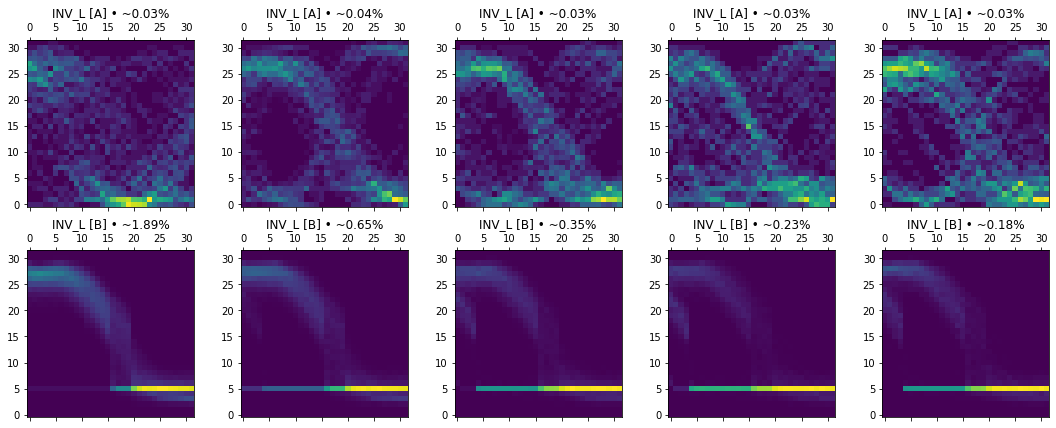

#### INV_R

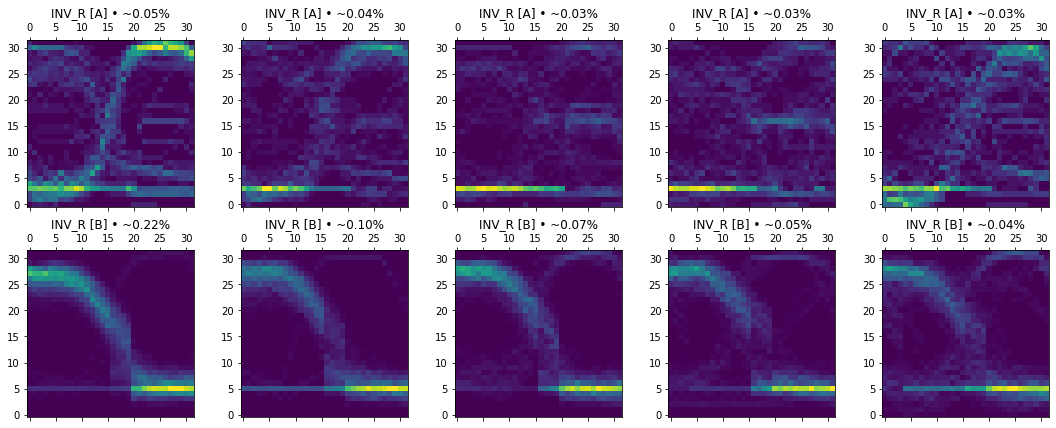

In [8]:
from IPython.display import Markdown as md
from group_motif import *

suffix = '_s64-32_w32_d2000_r40.json'
for js in sorted(glob.glob(f'./bin0412/motif_*{suffix}')):
    name = os.path.basename(js).replace('motif_HGDP_', '').replace(suffix, '')
    display(md(f"#### {name}"))
    plot_motif(js, suffix, x=32, y=32)

Поиск мотивов с меньшим сжатием (x4) и с меньшим окном (1/4, 1/8 сигнала)

```bash
for src in ./bin0412/*.bin; do
  python3 Clusters_KMS_bootstrap.py src:$src sax:128 alphabet:24 window:32 dataset:2000 repeats:40 &
  python3 Clusters_KMS_bootstrap.py src:$src sax:128 alphabet:24 window:16 dataset:2000 repeats:40 &
done
## .. В процессе
```